In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

In [2]:
data=yf.download('HSI','2018-01-01','2022-01-01')
data.drop('Volume',1,inplace=True)
data

[*********************100%***********************]  1 of 1 completed


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_54504/3609140658.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('Volume',1,inplace=True)


,Open,High,Low,Close,Adj Close
Date,,,,,
2018-01-02,30515.300781,30515.300781,30515.300781,30515.300781,30515.300781
2018-01-03,30560.900391,30560.900391,30560.900391,30560.900391,30560.900391
2018-01-04,30736.500000,30736.500000,30736.500000,30736.500000,30736.500000
2018-01-05,30814.599609,30814.599609,30814.599609,30814.599609,30814.599609
2018-01-08,30899.500000,30899.500000,30899.500000,30899.500000,30899.500000
...,...,...,...,...,...
2021-12-27,23223.800781,23223.800781,23223.800781,23223.800781,23223.800781
2021-12-28,23280.599609,23280.599609,23280.599609,23280.599609,23280.599609
2021-12-29,23086.500000,23086.500000,23086.500000,23086.500000,23086.500000


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_54504/1968958741.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  importance=mutual_info_regression(data.drop('Prediction',1),data['Prediction'])


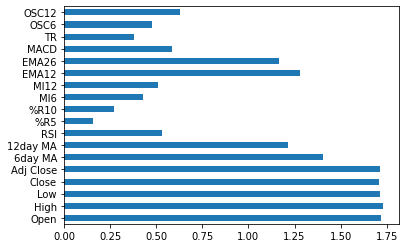

In [4]:
from sklearn.feature_selection import mutual_info_regression
importance=mutual_info_regression(data.drop('Prediction',1),data['Prediction'])
feature_importances=pd.Series(importance,data.columns[0:len(data.columns)-1])
feature_importances.plot(kind="barh")
plt.show()

In [5]:
data.drop(['OSC12','OSC6','MI12','MI6','%R10','%R5','RSI','TR'],1,inplace=True)
data_val=data[-100:]
data=data[:-100]
data_val.tail()

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_54504/244261082.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop(['OSC12','OSC6','MI12','MI6','%R10','%R5','RSI','TR'],1,inplace=True)


,Open,High,Low,Close,Adj Close,6day MA,12day MA,EMA12,EMA26,MACD,Prediction
Date,,,,,,,,,,,
2021-12-23,23193.599609,23193.599609,23193.599609,23193.599609,23193.599609,23113.366862,23494.916829,23397.249467,23841.259170,-444.009703,23223.800781
2021-12-27,23223.800781,23223.800781,23223.800781,23223.800781,23223.800781,23071.416992,23430.491862,23370.565054,23795.521511,-424.956457,23280.599609
2021-12-28,23280.599609,23280.599609,23280.599609,23280.599609,23280.599609,23086.083659,23349.300130,23356.724216,23757.379148,-400.654932,23086.500000
2021-12-29,23086.500000,23086.500000,23086.500000,23086.500000,23086.500000,23143.016927,23273.533529,23315.151260,23707.684396,-392.533137,23112.000000
2021-12-30,23112.000000,23112.000000,23112.000000,23112.000000,23112.000000,23166.466797,23203.316895,23283.897220,23663.559626,-379.662406,23397.699219


In [6]:
sc = MinMaxScaler(feature_range = (0, 1))
sc_y= MinMaxScaler(feature_range = (0, 1))

In [7]:
# data['Prediction']=data['Close'].shift(-1)
# data.dropna(inplace=True)
# data_val=data[-100:]
# data=data[:-100]
# data_val.tail()

In [8]:
X=sc.fit_transform(data.drop('Prediction',1))
#X=data.drop('Prediction',1).values
# Y = data["Prediction"].values.reshape(-1,1)
# Y = sc_y.fit_transform(data["Prediction"].values.reshape(-1,1))
Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(619, 1, 10) (619,) (69, 1, 10) (69,)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_54504/2884921294.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [9]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
    kernel_regularizer=regularizers.l1(0.01)
   
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

Metal device set to: Apple M1 Pro


2022-04-10 01:14:06.194395: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-10 01:14:06.194497: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.001)
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=1400,
    batch_size=128,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
#     callbacks=[es]
)
y_pred = model_tech.predict(X_test)

Epoch 1/1400
5/5 [==============================] - 0s 19ms/step - loss: 3371837.7500 - val_loss: 3648574.0000
Epoch 2/1400
5/5 [==============================] - 0s 13ms/step - loss: 3371786.7500 - val_loss: 3648697.7500
Epoch 3/1400
5/5 [==============================] - 0s 14ms/step - loss: 3371739.5000 - val_loss: 3648816.7500
Epoch 4/1400
5/5 [==============================] - 0s 15ms/step - loss: 3371694.2500 - val_loss: 3648935.7500
Epoch 5/1400
5/5 [==============================] - 0s 14ms/step - loss: 3371650.2500 - val_loss: 3649055.7500
Epoch 6/1400
5/5 [==============================] - 0s 13ms/step - loss: 3371610.2500 - val_loss: 3649168.7500
Epoch 7/1400
5/5 [==============================] - 0s 13ms/step - loss: 3371568.0000 - val_loss: 3649281.5000
Epoch 8/1400
5/5 [==============================] - 0s 13ms/step - loss: 3371529.2500 - val_loss: 3649393.0000
Epoch 9/1400
5/5 [==============================] - 0s 13ms/step - loss: 3371489.0000 - val_loss: 3649495.0000
E

5/5 [==============================] - 0s 24ms/step - loss: 689331.0625 - val_loss: 772145.0000
Epoch 75/1400
5/5 [==============================] - 0s 13ms/step - loss: 677989.0625 - val_loss: 760110.0000
Epoch 76/1400
5/5 [==============================] - 0s 16ms/step - loss: 666880.1250 - val_loss: 748319.1250
Epoch 77/1400
5/5 [==============================] - 0s 13ms/step - loss: 656000.0625 - val_loss: 736762.8125
Epoch 78/1400
5/5 [==============================] - 0s 15ms/step - loss: 645342.1250 - val_loss: 725434.8750
Epoch 79/1400
5/5 [==============================] - 0s 13ms/step - loss: 634899.7500 - val_loss: 714332.7500
Epoch 80/1400
5/5 [==============================] - 0s 14ms/step - loss: 624670.6875 - val_loss: 703451.7500
Epoch 81/1400
5/5 [==============================] - 0s 15ms/step - loss: 614648.9375 - val_loss: 692784.8125
Epoch 82/1400
5/5 [==============================] - 0s 13ms/step - loss: 604829.9375 - val_loss: 682327.5000
Epoch 83/1400
5/5 [=====

5/5 [==============================] - 0s 16ms/step - loss: 246103.6719 - val_loss: 294863.4062
Epoch 149/1400
5/5 [==============================] - 0s 15ms/step - loss: 243360.9531 - val_loss: 291838.8125
Epoch 150/1400
5/5 [==============================] - 0s 14ms/step - loss: 240663.3438 - val_loss: 288864.1562
Epoch 151/1400
5/5 [==============================] - 0s 13ms/step - loss: 238010.0312 - val_loss: 285936.9375
Epoch 152/1400
5/5 [==============================] - 0s 13ms/step - loss: 235399.6250 - val_loss: 283056.8438
Epoch 153/1400
5/5 [==============================] - 0s 14ms/step - loss: 232831.3125 - val_loss: 280223.5312
Epoch 154/1400
5/5 [==============================] - 0s 14ms/step - loss: 230304.5469 - val_loss: 277435.5000
Epoch 155/1400
5/5 [==============================] - 0s 15ms/step - loss: 227818.0469 - val_loss: 274692.2812
Epoch 156/1400
5/5 [==============================] - 0s 15ms/step - loss: 225371.1719 - val_loss: 271991.9062
Epoch 157/1400
5

Epoch 222/1400
5/5 [==============================] - 0s 15ms/step - loss: 121659.4766 - val_loss: 158491.9688
Epoch 223/1400
5/5 [==============================] - 0s 14ms/step - loss: 120684.0703 - val_loss: 157413.2500
Epoch 224/1400
5/5 [==============================] - 0s 15ms/step - loss: 119721.9453 - val_loss: 156346.0469
Epoch 225/1400
5/5 [==============================] - 0s 15ms/step - loss: 118773.0469 - val_loss: 155290.9062
Epoch 226/1400
5/5 [==============================] - 0s 15ms/step - loss: 117837.1172 - val_loss: 154246.8750
Epoch 227/1400
5/5 [==============================] - 0s 15ms/step - loss: 116914.1250 - val_loss: 153214.6094
Epoch 228/1400
5/5 [==============================] - 0s 14ms/step - loss: 116004.0469 - val_loss: 152193.2812
Epoch 229/1400
5/5 [==============================] - 0s 14ms/step - loss: 115106.7422 - val_loss: 151183.2031
Epoch 230/1400
5/5 [==============================] - 0s 30ms/step - loss: 114221.9766 - val_loss: 150184.0312
E

5/5 [==============================] - 0s 14ms/step - loss: 71373.3984 - val_loss: 103158.5234
Epoch 297/1400
5/5 [==============================] - 0s 13ms/step - loss: 70893.4219 - val_loss: 102638.8906
Epoch 298/1400
5/5 [==============================] - 0s 13ms/step - loss: 70417.4922 - val_loss: 102123.2109
Epoch 299/1400
5/5 [==============================] - 0s 13ms/step - loss: 69945.5078 - val_loss: 101611.5859
Epoch 300/1400
5/5 [==============================] - 0s 14ms/step - loss: 69477.2500 - val_loss: 101104.1094
Epoch 301/1400
5/5 [==============================] - 0s 14ms/step - loss: 69012.9453 - val_loss: 100600.5391
Epoch 302/1400
5/5 [==============================] - 0s 14ms/step - loss: 68552.4844 - val_loss: 100100.7812
Epoch 303/1400
5/5 [==============================] - 0s 14ms/step - loss: 68095.8438 - val_loss: 99605.0312
Epoch 304/1400
5/5 [==============================] - 0s 14ms/step - loss: 67642.9375 - val_loss: 99113.1719
Epoch 305/1400
5/5 [=======

5/5 [==============================] - 0s 14ms/step - loss: 44154.8945 - val_loss: 73257.9219
Epoch 372/1400
5/5 [==============================] - 0s 14ms/step - loss: 43887.1992 - val_loss: 72958.1016
Epoch 373/1400
5/5 [==============================] - 0s 14ms/step - loss: 43621.5195 - val_loss: 72660.6250
Epoch 374/1400
5/5 [==============================] - 0s 14ms/step - loss: 43357.7969 - val_loss: 72364.9531
Epoch 375/1400
5/5 [==============================] - 0s 14ms/step - loss: 43096.0000 - val_loss: 72071.4062
Epoch 376/1400
5/5 [==============================] - 0s 13ms/step - loss: 42836.1406 - val_loss: 71780.0156
Epoch 377/1400
5/5 [==============================] - 0s 14ms/step - loss: 42578.1602 - val_loss: 71490.3750
Epoch 378/1400
5/5 [==============================] - 0s 14ms/step - loss: 42322.0508 - val_loss: 71202.8594
Epoch 379/1400
5/5 [==============================] - 0s 13ms/step - loss: 42067.8867 - val_loss: 70917.4609
Epoch 380/1400
5/5 [==============

5/5 [==============================] - 0s 14ms/step - loss: 28654.1465 - val_loss: 55706.8320
Epoch 447/1400
5/5 [==============================] - 0s 14ms/step - loss: 28499.6582 - val_loss: 55530.2227
Epoch 448/1400
5/5 [==============================] - 0s 16ms/step - loss: 28346.2363 - val_loss: 55355.2461
Epoch 449/1400
5/5 [==============================] - 0s 15ms/step - loss: 28194.0176 - val_loss: 55181.4727
Epoch 450/1400
5/5 [==============================] - 0s 14ms/step - loss: 28042.9238 - val_loss: 55008.8750
Epoch 451/1400
5/5 [==============================] - 0s 14ms/step - loss: 27892.9297 - val_loss: 54837.7930
Epoch 452/1400
5/5 [==============================] - 0s 14ms/step - loss: 27744.0293 - val_loss: 54667.7266
Epoch 453/1400
5/5 [==============================] - 0s 14ms/step - loss: 27596.2617 - val_loss: 54499.1016
Epoch 454/1400
5/5 [==============================] - 0s 14ms/step - loss: 27449.5742 - val_loss: 54331.7148
Epoch 455/1400
5/5 [==============

5/5 [==============================] - 0s 14ms/step - loss: 19758.3867 - val_loss: 45556.7344
Epoch 522/1400
5/5 [==============================] - 0s 14ms/step - loss: 19670.4961 - val_loss: 45450.1094
Epoch 523/1400
5/5 [==============================] - 0s 14ms/step - loss: 19580.2441 - val_loss: 45338.2812
Epoch 524/1400
5/5 [==============================] - 0s 14ms/step - loss: 19489.5547 - val_loss: 45229.1758
Epoch 525/1400
5/5 [==============================] - 0s 14ms/step - loss: 19401.2500 - val_loss: 45125.9570
Epoch 526/1400
5/5 [==============================] - 0s 14ms/step - loss: 19315.6016 - val_loss: 45027.2891
Epoch 527/1400
5/5 [==============================] - 0s 13ms/step - loss: 19231.3438 - val_loss: 44930.9961
Epoch 528/1400
5/5 [==============================] - 0s 13ms/step - loss: 19147.7578 - val_loss: 44836.1680
Epoch 529/1400
5/5 [==============================] - 0s 13ms/step - loss: 19064.6172 - val_loss: 44741.1992
Epoch 530/1400
5/5 [==============

5/5 [==============================] - 0s 14ms/step - loss: 14342.9395 - val_loss: 38570.1719
Epoch 597/1400
5/5 [==============================] - 0s 13ms/step - loss: 14285.0166 - val_loss: 38493.1328
Epoch 598/1400
5/5 [==============================] - 0s 13ms/step - loss: 14227.8125 - val_loss: 38417.7500
Epoch 599/1400
5/5 [==============================] - 0s 13ms/step - loss: 14171.2539 - val_loss: 38343.8125
Epoch 600/1400
5/5 [==============================] - 0s 13ms/step - loss: 14115.3281 - val_loss: 38271.6836
Epoch 601/1400
5/5 [==============================] - 0s 13ms/step - loss: 14060.0449 - val_loss: 38200.9375
Epoch 602/1400
5/5 [==============================] - 0s 13ms/step - loss: 14005.3633 - val_loss: 38131.2695
Epoch 603/1400
5/5 [==============================] - 0s 13ms/step - loss: 13951.2002 - val_loss: 38062.7148
Epoch 604/1400
5/5 [==============================] - 0s 13ms/step - loss: 13897.4766 - val_loss: 37994.9766
Epoch 605/1400
5/5 [==============

5/5 [==============================] - 0s 14ms/step - loss: 10887.4199 - val_loss: 34188.2617
Epoch 672/1400
5/5 [==============================] - 0s 13ms/step - loss: 10849.9062 - val_loss: 34139.2344
Epoch 673/1400
5/5 [==============================] - 0s 14ms/step - loss: 10812.6152 - val_loss: 34090.3242
Epoch 674/1400
5/5 [==============================] - 0s 13ms/step - loss: 10775.4688 - val_loss: 34041.4336
Epoch 675/1400
5/5 [==============================] - 0s 13ms/step - loss: 10738.5742 - val_loss: 33992.9062
Epoch 676/1400
5/5 [==============================] - 0s 13ms/step - loss: 10701.8604 - val_loss: 33944.6133
Epoch 677/1400
5/5 [==============================] - 0s 14ms/step - loss: 10665.3496 - val_loss: 33896.3125
Epoch 678/1400
5/5 [==============================] - 0s 14ms/step - loss: 10628.9863 - val_loss: 33848.1797
Epoch 679/1400
5/5 [==============================] - 0s 14ms/step - loss: 10592.8340 - val_loss: 33800.2148
Epoch 680/1400
5/5 [==============

Epoch 747/1400
5/5 [==============================] - 0s 13ms/step - loss: 8522.4082 - val_loss: 30696.8242
Epoch 748/1400
5/5 [==============================] - 0s 13ms/step - loss: 8497.2861 - val_loss: 30650.4004
Epoch 749/1400
5/5 [==============================] - 0s 13ms/step - loss: 8472.4766 - val_loss: 30603.7266
Epoch 750/1400
5/5 [==============================] - 0s 13ms/step - loss: 8448.0420 - val_loss: 30557.0801
Epoch 751/1400
5/5 [==============================] - 0s 12ms/step - loss: 8423.9463 - val_loss: 30510.3418
Epoch 752/1400
5/5 [==============================] - 0s 13ms/step - loss: 8400.3545 - val_loss: 30463.2754
Epoch 753/1400
5/5 [==============================] - 0s 13ms/step - loss: 8377.0967 - val_loss: 30416.0508
Epoch 754/1400
5/5 [==============================] - 0s 13ms/step - loss: 8354.1348 - val_loss: 30368.1387
Epoch 755/1400
5/5 [==============================] - 0s 13ms/step - loss: 8331.1387 - val_loss: 30319.0566
Epoch 756/1400
5/5 [========

Epoch 823/1400
5/5 [==============================] - 0s 13ms/step - loss: 6906.2876 - val_loss: 26755.7598
Epoch 824/1400
5/5 [==============================] - 0s 13ms/step - loss: 6888.9004 - val_loss: 26698.3418
Epoch 825/1400
5/5 [==============================] - 0s 13ms/step - loss: 6870.9658 - val_loss: 26640.1035
Epoch 826/1400
5/5 [==============================] - 0s 13ms/step - loss: 6853.0127 - val_loss: 26580.8008
Epoch 827/1400
5/5 [==============================] - 0s 13ms/step - loss: 6835.4448 - val_loss: 26520.0000
Epoch 828/1400
5/5 [==============================] - 0s 13ms/step - loss: 6818.3740 - val_loss: 26457.5664
Epoch 829/1400
5/5 [==============================] - 0s 13ms/step - loss: 6801.5688 - val_loss: 26393.8574
Epoch 830/1400
5/5 [==============================] - 0s 13ms/step - loss: 6784.7227 - val_loss: 26328.9004
Epoch 831/1400
5/5 [==============================] - 0s 13ms/step - loss: 6767.4902 - val_loss: 26263.2910
Epoch 832/1400
5/5 [========

Epoch 899/1400
5/5 [==============================] - 0s 13ms/step - loss: 5770.8491 - val_loss: 21527.8711
Epoch 900/1400
5/5 [==============================] - 0s 13ms/step - loss: 5756.9453 - val_loss: 21457.7656
Epoch 901/1400
5/5 [==============================] - 0s 13ms/step - loss: 5747.4858 - val_loss: 21385.4414
Epoch 902/1400
5/5 [==============================] - 0s 13ms/step - loss: 5739.1143 - val_loss: 21309.2324
Epoch 903/1400
5/5 [==============================] - 0s 13ms/step - loss: 5727.6421 - val_loss: 21234.5195
Epoch 904/1400
5/5 [==============================] - 0s 13ms/step - loss: 5712.7407 - val_loss: 21165.5684
Epoch 905/1400
5/5 [==============================] - 0s 13ms/step - loss: 5697.9268 - val_loss: 21097.6992
Epoch 906/1400
5/5 [==============================] - 0s 13ms/step - loss: 5685.9058 - val_loss: 21022.9297
Epoch 907/1400
5/5 [==============================] - 0s 14ms/step - loss: 5675.9360 - val_loss: 20938.6719
Epoch 908/1400
5/5 [========

Epoch 975/1400
5/5 [==============================] - 0s 13ms/step - loss: 4864.4209 - val_loss: 15931.1025
Epoch 976/1400
5/5 [==============================] - 0s 13ms/step - loss: 4854.1650 - val_loss: 15863.6943
Epoch 977/1400
5/5 [==============================] - 0s 13ms/step - loss: 4843.0264 - val_loss: 15797.4277
Epoch 978/1400
5/5 [==============================] - 0s 13ms/step - loss: 4830.9004 - val_loss: 15734.3330
Epoch 979/1400
5/5 [==============================] - 0s 13ms/step - loss: 4819.0449 - val_loss: 15672.1836
Epoch 980/1400
5/5 [==============================] - 0s 12ms/step - loss: 4808.3149 - val_loss: 15606.2021
Epoch 981/1400
5/5 [==============================] - 0s 13ms/step - loss: 4798.1245 - val_loss: 15536.1426
Epoch 982/1400
5/5 [==============================] - 0s 13ms/step - loss: 4787.1196 - val_loss: 15465.7549
Epoch 983/1400
5/5 [==============================] - 0s 13ms/step - loss: 4774.7466 - val_loss: 15399.4697
Epoch 984/1400
5/5 [========

5/5 [==============================] - 0s 13ms/step - loss: 4048.6873 - val_loss: 11689.6963
Epoch 1051/1400
5/5 [==============================] - 0s 13ms/step - loss: 4037.5037 - val_loss: 11645.4248
Epoch 1052/1400
5/5 [==============================] - 0s 13ms/step - loss: 4026.9634 - val_loss: 11603.4756
Epoch 1053/1400
5/5 [==============================] - 0s 12ms/step - loss: 4017.2605 - val_loss: 11557.7168
Epoch 1054/1400
5/5 [==============================] - 0s 12ms/step - loss: 4007.2312 - val_loss: 11507.7910
Epoch 1055/1400
5/5 [==============================] - 0s 13ms/step - loss: 3996.4475 - val_loss: 11459.4355
Epoch 1056/1400
5/5 [==============================] - 0s 12ms/step - loss: 3985.7617 - val_loss: 11415.4941
Epoch 1057/1400
5/5 [==============================] - 0s 13ms/step - loss: 3976.1279 - val_loss: 11372.4736
Epoch 1058/1400
5/5 [==============================] - 0s 13ms/step - loss: 3967.0181 - val_loss: 11326.6895
Epoch 1059/1400
5/5 [==============

5/5 [==============================] - 0s 13ms/step - loss: 3327.4507 - val_loss: 8840.3975
Epoch 1126/1400
5/5 [==============================] - 0s 13ms/step - loss: 3316.9407 - val_loss: 8802.0371
Epoch 1127/1400
5/5 [==============================] - 0s 12ms/step - loss: 3305.1694 - val_loss: 8770.8613
Epoch 1128/1400
5/5 [==============================] - 0s 13ms/step - loss: 3295.3345 - val_loss: 8745.4512
Epoch 1129/1400
5/5 [==============================] - 0s 13ms/step - loss: 3287.1548 - val_loss: 8714.9287
Epoch 1130/1400
5/5 [==============================] - 0s 13ms/step - loss: 3277.4551 - val_loss: 8679.7959
Epoch 1131/1400
5/5 [==============================] - 0s 13ms/step - loss: 3265.9722 - val_loss: 8650.3135
Epoch 1132/1400
5/5 [==============================] - 0s 13ms/step - loss: 3255.6350 - val_loss: 8626.1982
Epoch 1133/1400
5/5 [==============================] - 0s 13ms/step - loss: 3246.8154 - val_loss: 8597.5195
Epoch 1134/1400
5/5 [=======================

5/5 [==============================] - 0s 13ms/step - loss: 2470.4204 - val_loss: 6455.1333
Epoch 1202/1400
5/5 [==============================] - 0s 13ms/step - loss: 2456.4688 - val_loss: 6432.0723
Epoch 1203/1400
5/5 [==============================] - 0s 15ms/step - loss: 2445.9629 - val_loss: 6401.6299
Epoch 1204/1400
5/5 [==============================] - 0s 13ms/step - loss: 2434.1733 - val_loss: 6358.8311
Epoch 1205/1400
5/5 [==============================] - 0s 13ms/step - loss: 2419.4788 - val_loss: 6321.2197
Epoch 1206/1400
5/5 [==============================] - 0s 13ms/step - loss: 2405.9880 - val_loss: 6295.2578
Epoch 1207/1400
5/5 [==============================] - 0s 13ms/step - loss: 2395.4978 - val_loss: 6265.7192
Epoch 1208/1400
5/5 [==============================] - 0s 24ms/step - loss: 2384.0208 - val_loss: 6226.3979
Epoch 1209/1400
5/5 [==============================] - 0s 13ms/step - loss: 2369.5188 - val_loss: 6191.7354
Epoch 1210/1400
5/5 [=======================

5/5 [==============================] - 0s 13ms/step - loss: 1737.0446 - val_loss: 4532.8521
Epoch 1278/1400
5/5 [==============================] - 0s 17ms/step - loss: 1727.8138 - val_loss: 4513.8701
Epoch 1279/1400
5/5 [==============================] - 0s 13ms/step - loss: 1719.4535 - val_loss: 4506.9214
Epoch 1280/1400
5/5 [==============================] - 0s 13ms/step - loss: 1714.2018 - val_loss: 4489.1826
Epoch 1281/1400
5/5 [==============================] - 0s 13ms/step - loss: 1707.7446 - val_loss: 4458.3423
Epoch 1282/1400
5/5 [==============================] - 0s 13ms/step - loss: 1698.5027 - val_loss: 4435.9224
Epoch 1283/1400
5/5 [==============================] - 0s 13ms/step - loss: 1690.8926 - val_loss: 4426.1602
Epoch 1284/1400
5/5 [==============================] - 0s 13ms/step - loss: 1686.8372 - val_loss: 4408.7231
Epoch 1285/1400
5/5 [==============================] - 0s 13ms/step - loss: 1681.2811 - val_loss: 4379.6509
Epoch 1286/1400
5/5 [=======================

5/5 [==============================] - 0s 13ms/step - loss: 1296.6248 - val_loss: 3238.6143
Epoch 1354/1400
5/5 [==============================] - 0s 13ms/step - loss: 1290.7195 - val_loss: 3235.0352
Epoch 1355/1400
5/5 [==============================] - 0s 13ms/step - loss: 1287.6290 - val_loss: 3218.5710
Epoch 1356/1400
5/5 [==============================] - 0s 12ms/step - loss: 1283.8131 - val_loss: 3192.4263
Epoch 1357/1400
5/5 [==============================] - 0s 13ms/step - loss: 1277.3997 - val_loss: 3177.3423
Epoch 1358/1400
5/5 [==============================] - 0s 13ms/step - loss: 1271.9821 - val_loss: 3173.0623
Epoch 1359/1400
5/5 [==============================] - 0s 13ms/step - loss: 1269.8774 - val_loss: 3158.0186
Epoch 1360/1400
5/5 [==============================] - 0s 13ms/step - loss: 1266.2024 - val_loss: 3132.8291
Epoch 1361/1400
5/5 [==============================] - 0s 12ms/step - loss: 1258.8177 - val_loss: 3121.4497
Epoch 1362/1400
5/5 [=======================

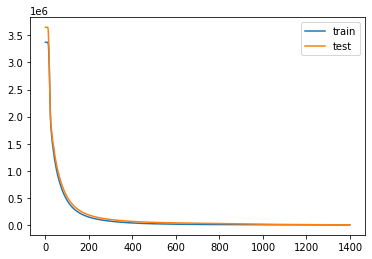

In [23]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

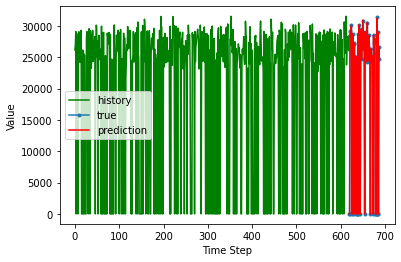

In [24]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
# plt.plot(np.arange(0, len(y_train)), sc_y.inverse_transform(y_train), 'g', label="history")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_test), marker='.', label="true")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_pred), 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

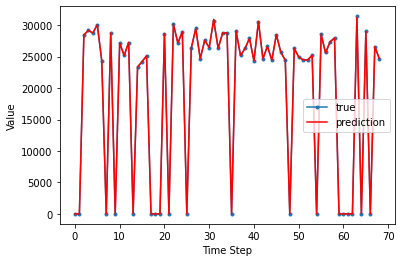

In [25]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [26]:
r2_score(y_test,y_pred)

0.9999903016805217

In [27]:
mean_absolute_percentage_error(y_test,y_pred)

4.227383241917981

In [28]:
mean_squared_error(y_test,y_pred,squared=False)

37.95810257704109

In [29]:
x_val=data_val.drop('Prediction',1).values
y_val=data_val['Prediction']
# x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)
# y_val_pred=sc_y.inverse_transform(y_val_pred)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_54504/2175021245.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1).values
/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


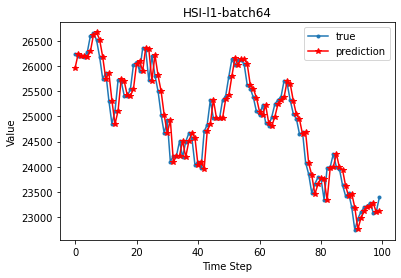

In [30]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSI-l1-batch64')
plt.legend()
plt.show()

In [31]:
r2_score(y_val,y_val_pred)

0.912803829333188

In [32]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.009465446720040039

In [33]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

299.42019419912947